<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2025/blob/main/Module_6/30_GPax_BO_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based Bayesian optimization

The notebook for the University of Tennessee, Knoxville, Department of Materials Science and Engineering Spring 2025 course, MSE510.

- Prepared by Maxim Ziatdinov (2022), https://scholar.google.com/citations?user=YnSdOoUAAAAJ

- Adapted by Sergey V. Kalinin (2023), https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ

- If you are interested in GP/BO for automated experiment, check GPax repository (https://github.com/ziatdinovmax/gpax) and add your stars!

# Simple case: Upper Confidence Bound

As described in earlier examples, Gaussian process (GP) is a powerful tool for reconstructing an unknown function from sparse measurements in the probabilistic fashion. In addition to providing a "one-off" reconstruction, the GP's posterior predictive mean and uncertainty can be used to derive an acquisition function for selecting the next point to measure in the optimization problems. Specifically, the next measurement point is selected according to

$$ x_{next}= \underset{x}{\arg\max}\frac{1}{L}‚àë_{i=1}^LŒ±(ùúá_*^i,ùì•_*^i)$$

for maximization problems and

$$ x_{next}= \underset{x}{\arg\min}\frac{1}{L}‚àë_{i=1}^LŒ±(ùúá_*^i,ùì•_*^i)$$

for minimization problems. Here $L$ is the total number of Hamiltonian Monte Carlo samples,  $ùúá_*^i$ is a posterior predictive mean, and $ùì•_*^i$ is a posterior predictive variance for *i*-th sample. Perhaps the simplest acquisition function is an upper confidence bound (UCB) defined as

$$ Œ±_{UCB}^i= ùúá_*^i\pm\sqrt{ùõΩ\space ùì•_*^i}, $$

where the square root of ùì• is a standard deviation (‚Äòuncertainty‚Äô). We note that instead of $\frac{1}{L}‚àë_{i=1}^LŒ±(ùúá_*^i,ùì•_*^i)$, one could in principle use $Œ±(\bar{f_*}, ùì•[f_*])$, where $\bar{f_*}$ and $ùì•[f_*]$ are the mean and variance of predictions sampled from the multivariate normal posterior at each point (```y_sampled``` in gpax examples).  The coefficient $ùõΩ$ determines an exploitation-exploration trade-off. The '$+$' sign corresponds to the maximization problems, whereas the '$-$' sign is for the minimization problems.


# Acquisition functions in GPax

Here, we will use only the Upper Confidence Bound (UCB), Expected Improvement (EI), and Uncertainty Exploration (EU), but it is a good idea to have a look at which ones are available in GPax. Note that each acquisition function has hyperparameters that define how it works - we will illustrate them below.  

1. **Upper confidence bound**

gpax.acquisition.UCB(rng_key, model, X, beta=0.25, maximize=False, n=1, noiseless=False, **kwargs)

Parameters
- rng_key (Array) ‚Äì JAX random number generator key
- model (Type[ExactGP]) ‚Äì trained model
- X (Array) ‚Äì new inputs
- beta (float) ‚Äì coefficient balancing exploration-exploitation trade-off
- maximize (bool) ‚Äì If True, assumes that BO is solving maximization problem
- n (int) ‚Äì number of samples drawn from each MVN distribution (number of distributions is equal to the number of HMC samples)
- noiseless (bool) ‚Äì Noise-free prediction. It is set to False by default as new/unseen data is assumed to follow the same distribution as the training data. Hence, since we introduce a model noise for the training data, we also want to include that noise in our prediction.

2. **Expected Improvement**

gpax.acquisition.EI(rng_key, model, X, xi=0.01, maximize=False, n=1, noiseless=False, **kwargs)

Parameters:
- rng_key (Array) ‚Äì JAX random number generator key
model (Type[ExactGP]) ‚Äì trained model
- X (Array) ‚Äì new inputs
- xi (float) ‚Äì coefficient balancing exploration-exploitation trade-off
- maximize (bool) ‚Äì If True, assumes that BO is solving maximization problem
- n (int) ‚Äì number of samples drawn from each MVN distribution (number of distributions is equal to the number of HMC samples)
- noiseless (bool) ‚Äì Noise-free prediction. It is set to False by default as new/unseen data is assumed to follow the same distribution as the training data. Hence, since we introduce a model noise for the training data, we also want to include that noise in our prediction.

3. **Thompson sampling**

gpax.acquisition.Thompson(rng_key, model, X, n=1, noiseless=False, **kwargs)

Parameters:
- rng_key (Array) ‚Äì JAX random number generator key
- model (Type[ExactGP]) ‚Äì trained model
- X (Array) ‚Äì new inputs
- n (int) ‚Äì number of samples drawn from the randomly selected MVN distribution
- noiseless (bool) ‚Äì Noise-free prediction. It is set to False by default as new/unseen data is assumed to follow the same distribution as the training data. Hence, since we introduce a model noise for the training data, we also want to include that noise in our prediction.

4. **Uncertainty-based exploration**

gpax.acquisition.UE(rng_key, model, X, n=1, noiseless=False, **kwargs)

Parameters:
- rng_key (Array) ‚Äì JAX random number generator key
- model (Type[ExactGP]) ‚Äì trained model
- X (Array) ‚Äì new inputs
- n (int) ‚Äì number of samples drawn from each MVN distribution (number of distributions is equal to the number of HMC samples)
- noiseless (bool) ‚Äì Noise-free prediction. It is set to False by default as new/unseen data is assumed to follow the same distribution as the training data. Hence, since we introduce a model noise for the training data, we also want to include that noise in our prediction.

5. **Batch Upper Confidence Bound**

gpax.acquisition.bUCB(rng_key, model, X, indices=None, batch_size=4, alpha=1.0, beta=0.25, maximize=True, n=500, n_restarts=20, noiseless=False, **kwargs)

The acquisition function defined as alpha * mu + sqrt(beta) * sigma that can output a ‚Äúbatch‚Äù of next points to evaluate. It takes advantage of the fact that in MCMC-based GP or DKL we obtain a separate multivariate normal posterior for each set of sampled kernel hyperparameters.

Parameters:
- rng_key (Array) ‚Äì random number generator key
- model (Type[ExactGP]) ‚Äì ExactGP or DKL type of model
- X (Array) ‚Äì input array
- indices (Optional[Array]) ‚Äì indices of data points in X array. For example, if each data point is an image patch, the indices should correspond to their (x, y) coordinates in the original image.
- batch_size (int) ‚Äì desired number of sampled points (default: 4)
- alpha (float) ‚Äì coefficient before mean prediction term (default: 1.0)
- beta (float) ‚Äì coefficient before variance term (default: 0.25)
- maximize (bool) ‚Äì sign of variance term (+/- if True/False)
- n (int) ‚Äì number of draws from each multivariate normal posterior
- n_restarts (int) ‚Äì number of restarts to find a batch of maximally separated points to evaluate next
- noiseless (bool) ‚Äì noise-free prediction for new/test data (default: False)

# Installation of GPax

In [ ]:
!pip install gpax #git+https://github.com/ziatdinovmax/gpax

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 103.4/103.4 kB 2.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 373.9/373.9 kB 5.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 365.8/365.8 kB 18.7 MB/s eta 0:00:00


Imports:

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro

gpax.utils.enable_x64()

# Define data generation process (ground truth):

Let's define a function to be minimized and a function that emulates a noisy measurement. The function is ground truth. This is how nature behaves, but we do not know it. Purpose of the experiment is either learn this function (EU aquisition function), or discover minimum of this function (UCB or EI aquisition function). Note that parameter beta in UCB determines balance between the explorationa and exploitation (if we set beta to zero, we make algorithm greedy so it get trapped into whatever minimum it discovers first). Also note that the noise that we add is a measurement noise that we define a priori. Experimentalist does not know what it is - you actually aim to learn it from the experiment.

In [ ]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

def measure(x, noise=0.01):
    return func(x) + noise * np.random.randn(len(x))

Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere.

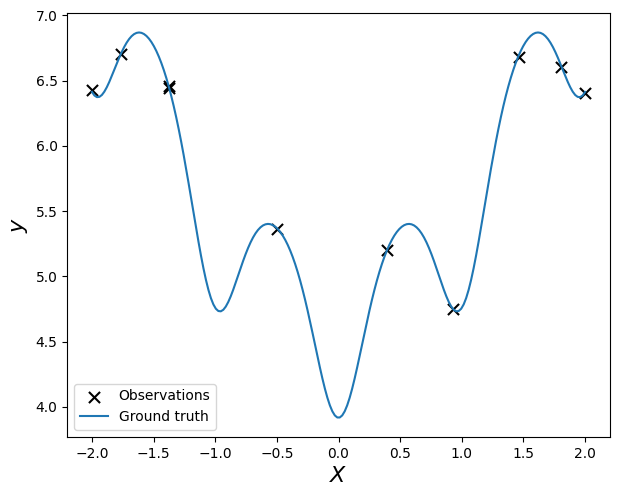

In [ ]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(8,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

# Define Gaussian Process Priors

The Gaussian process class in GPax uses a weakly informative $LogNormal(0,1)$ prior distribution for all kernel parameters and model noise by default. If we have prior knowledge that the noise level is low, we may choose a more appropriate prior distibution for the noise, such as

Priors on noise and kernel length and scale are our best guesses before the experiment on how the measurement system behaves. Noise is combined effect of how precise are our measurements and how significant are other (uncontrollable) factors that affect the measurements. Kernel lengthscale is basically how rapidly we think the properties can change. Scale is simplest - it is just vertical scale. These guesses are very important - for example, if we think that our measurements are very precise (noise is small) but in reality noise is high, then algorithm will interpret each noise peak as as peak in ground truth (and can go horribly wrong by making kernel length very small). At the same time, if we set kernel length too large, it can never find small modulations in the function. Experiment with these paprameters! Noise in the ground truth vs. noise in the prior, and too big/too small kernel lengths.

In [ ]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)) #Uniform(0.01, 1)) #

In [ ]:
def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.1, 2)) #0.1 2
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale}

It is a good idea to see what these distirbutions mean: HalfNormal, Uniform, LogNormal, Gamma, .... . You can use the following code snippet to visualize them:

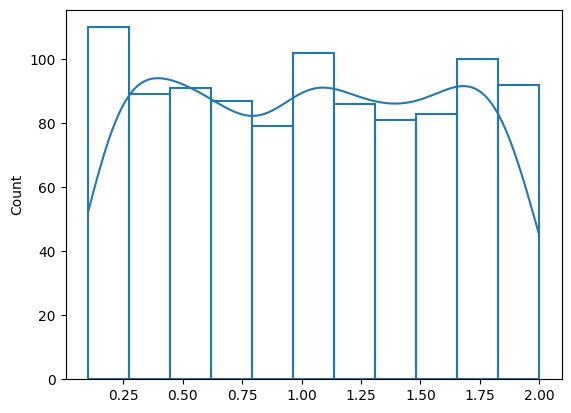

In [ ]:
d = numpyro.distributions.Uniform(0.1, 2) #Gamma(1, 1)
gpax.utils.dviz(d, samples=1000)

# Define Acquisition Function

Next we define a single step that takes measured data, trains a GP model, and uses it to compute an Upper Confidence Bound (UCB) acquisition function for deriving the next measurment point (which will be done inside the main loop).

In [ ]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior=gp_kernel_prior, noise_prior=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True, n= 10)

    # Compute acquisition function

    #Upper confidence bound
    obj = gpax.acquisition.UCB(rng_key2, gp_model, X_unmeasured, beta= 0.05, maximize=False, noiseless=True)

    #Expected improvement
    #obj = gpax.acquisition.EI(rng_key2, gp_model, X_unmeasured, xi=0.01, maximize=False, n=10, noiseless=True) #xi = 0.01

    # pure uncertainty-based
    #obj = gpax.acquisition.UE(rng_key2, gp_model, X_unmeasured, noiseless=True)

    return obj, (y_pred, y_sampled)

# Run Bayesian Optimization

Finally, we run the Bayesian optimization for N steps to find the minimum of the unknown (to the algorithm) function:


Step 1/5


/usr/local/lib/python3.11/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4000/4000 [00:06<00:00, 595.39it/s, 3 steps of size 3.92e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.41      0.26      1.39      1.00      1.88    616.16      1.00
   k_scale     12.47      5.91     11.02      4.79     21.17    818.04      1.00
     noise      0.02      0.02      0.02      0.00      0.05    679.49      1.00



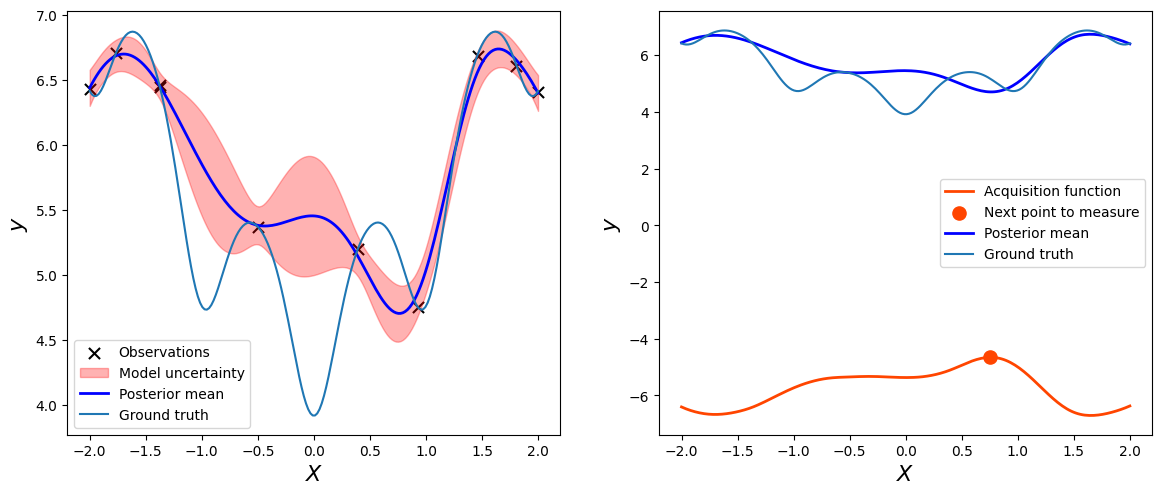


Step 2/5


sample: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4000/4000 [00:05<00:00, 708.86it/s, 3 steps of size 4.15e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.50      0.29      1.53      1.09      2.00    700.31      1.00
   k_scale     11.64      5.69     10.35      4.22     18.73   1046.34      1.00
     noise      0.04      0.02      0.04      0.01      0.07    807.17      1.00



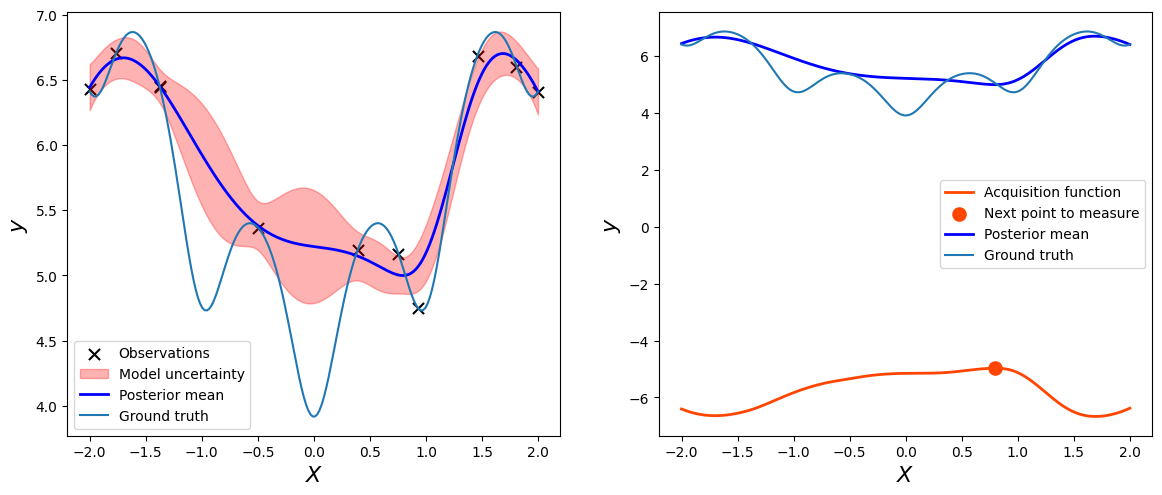


Step 3/5


sample: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4000/4000 [00:07<00:00, 533.70it/s, 7 steps of size 2.18e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.42      0.33      1.44      0.96      2.00    473.71      1.00
   k_scale     12.05      6.18     10.52      4.36     20.19    602.79      1.00
     noise      0.03      0.02      0.03      0.00      0.06    472.16      1.00



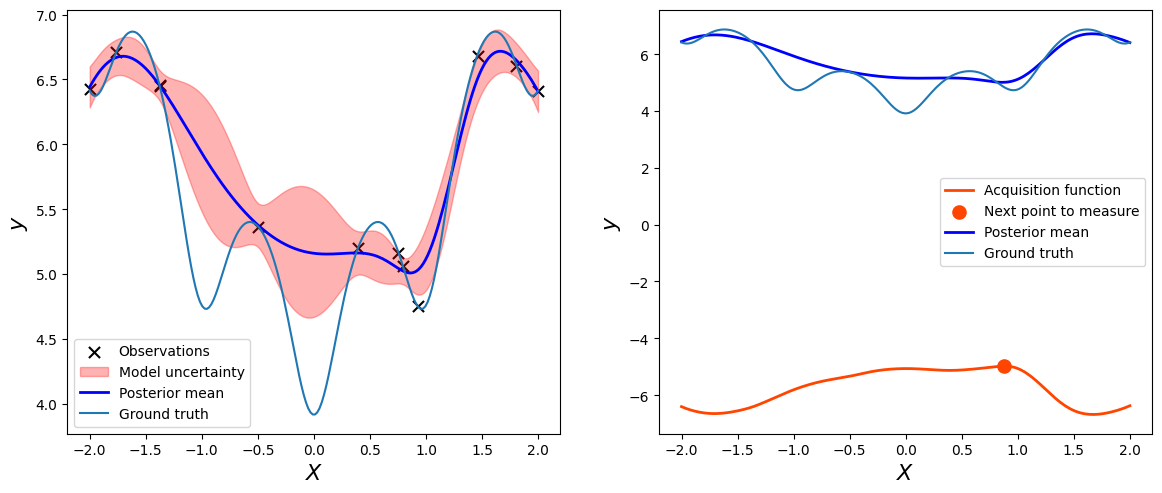


Step 4/5


sample: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4000/4000 [00:06<00:00, 594.49it/s, 7 steps of size 2.67e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.20      0.31      1.13      0.75      1.74    388.62      1.00
   k_scale     13.29      6.64     11.66      4.60     22.39    625.22      1.00
     noise      0.02      0.02      0.01      0.00      0.05    372.42      1.00



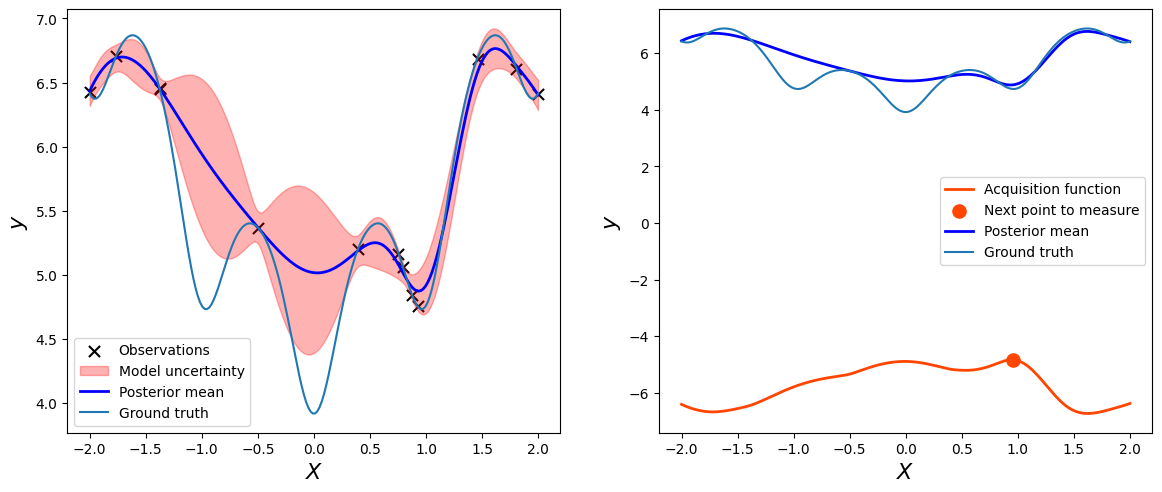


Step 5/5


sample: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4000/4000 [00:06<00:00, 583.94it/s, 3 steps of size 3.61e-01. acc. prob=0.92] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.02      0.17      1.01      0.77      1.27    754.73      1.01
   k_scale     13.89      6.08     12.56      5.09     22.46    844.35      1.00
     noise      0.00      0.01      0.00      0.00      0.00    316.73      1.00



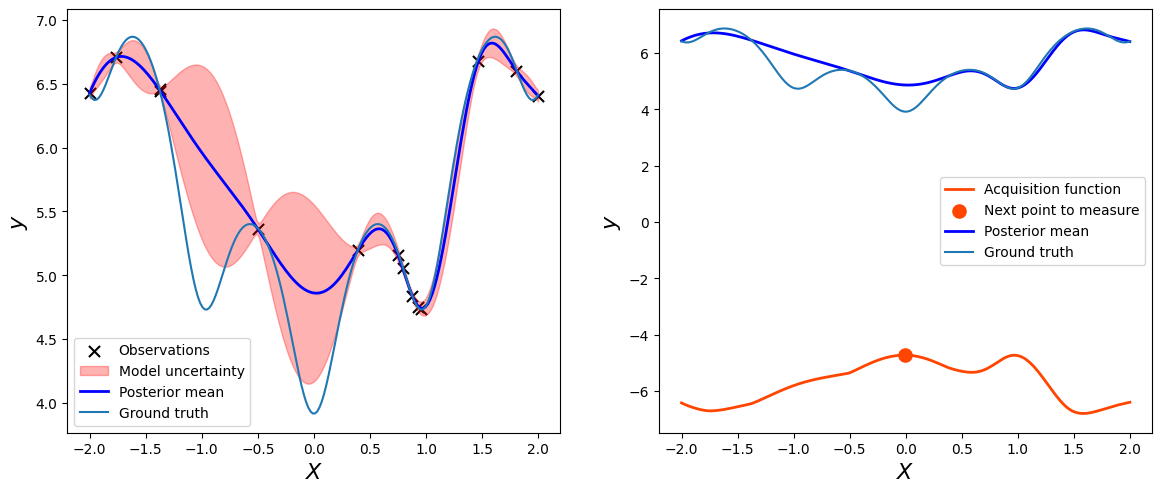

In [ ]:
num_steps = 5

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]

    # Measure the point
    next_point_value = measure(next_point)
    #Note that in experiment this is the step when you go to the lab. Strong insentive to learn how to make convergence faster!

    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
        ax.plot(X_unmeasured, ground_truth, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

As one can see, the algorithm quickly converged onto the true minimum. Note that in real experiments, it's practical to update the ```X_unmeasured``` at each step by removing the just measured point from it.

Also, observe how the kernel parameters and noise are changing with the iterations. You see scientific discovery process in action!

As the next step, lets look at the posterior predictive distributions to see what they look like:



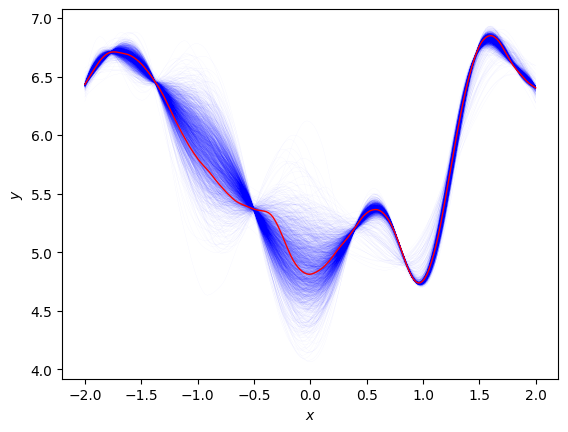

In [ ]:
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
#ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_unmeasured, y1.mean(0), lw=.1, zorder=0, c='b', alpha=.1)
l, = ax.plot(X_unmeasured, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")

General comments:
1. We can vary the exploration and exploitation via the choice of acquisition function and acquisition function hyperparameters
2. The results depends on the underpinning GP
3. Note that that the choice of policy guides the GP in turn, since the GP model uses the previous experiments to refine the model
4. Pay attention to the signs of acquisition function: the maximize = True/False and use of argmin/argmax in the BO loop. These should be matched to specific problem we are interested in (maximization or minimization).
5. Note that classical BO texts will start with normalizing the function and then run BO. In experiment, we often do not have such opportunity
6. Important note: BO is "myopic" - meaning that plans only for next step. There is way to extend it to multiple steps via so called utility functions, but we will not go there.




As an experiment, try:

1. It is important to keep track of the maximize = True/False argument in the acquisition functions, and choose argmin/argmax for the Batesian Optimization step accordingly. Note that "show the source" option in Colab allows to visualize the code that implements these function

2. Choose the noise to be 0.01 (small) and noise prior 0.01. Keep kernel length to be U(0.1, 2). These parameters allow the GP part to work well (but you can always play with what happens when GP is configured in the non-optimal fashion)

3. Explore the UCB(beta=0.01, maximize=False) (also, keep in mind that argmin!). UCB is easiest to understand aquisition function, since it simply combines the mean and uncertainty to make a decision. Pay attention to how the algorithm makes selection between leftmost and central minimum. Hint - it should converge to the cetral (right) minimum.

4. When observing the process, keep track of:

> 4.a. The ground truth. Algorithm does now know it - it is a guide for you to check how things work.

> 4.b. The measurement points - including the original ones and the ones that are added as a result of a new measurement

> 4.c. The reconstructed function (posterior mean function). This is what the algorithm thinks our function is. As an interesting excercise - try to think how would *you* draw the function if you had access to the measurement points but not the ground truth (hint: you can comment out the corresponding line in the code)

> 4.d. The shaded red region - this is our uncertainty (meaning mean function plus/minus sigma)

> 4.e. The red curve is the aquisition function. This is how the algorithm assigns *the measure of interest* to all points in the parameter space. We choose the next measurement point as the one that is most interesting for our setting (argmin or argmax)

> 4.f. It is very instructive to go through the details of the evolution of acquisitoin function and mean function from step to step.

5. Now set beta = 0.0001 (run the code from the beginning to reset the GP model - otherwise it will continue from previous state). When beta is small, it means that we define our interest primarily based on the expected value (go greedy, favor exploitation). What happens in this case? Hint - you should see convergence to the rightmost (incorrect) minimim.

6. Now set beta = 10 (very large). This favors exploration - basically, we set premium on minimizing uncertainty rather then achieving our optimization goal. What happens in this case? Hint - you will explore all minimima.

7. Next question will be of course why not set beta to be very high? In this case, we are going to find all the minima, right? Well, it's true, but check how many steps it takes if you set beta 10 and 25 (also, increase the number of cycles to 20).

8. Of course, play with other functions (EI), and see how hyperparameters affect BO in this case.

9. And if you are curious, explore how the *wrong* values of GP priors that we have explored in the previous notebook affect the BO process. It can be pretty educational!



Some observations you may make is that if you are greedy from the beginning, it is really easy to fall into the local minimim. At the same time, being too curious can require longer to learn. There are severla ways to avoid it, including
1. Hyperparameter tuning  
2. Anneal policies (go from pure exploration to more exploitation)
3. Use ensembles of the aquisition functions

If you feel adventurous and want to play with the code, consider
1. Rewriting it in such a way that beta in UCB becomes a parameter that changes during the BO
2. Use the ensemble of aquisition function and choose the one to follow randomly at each step
3. Use the ensemble of acquisition functions and take the prediction from the best.

You may not see much difference for the simple problem here, but these strategies are good to know for more complex systems!